## Twitter - Sentiment Analysis

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import sklearn

### Read data

In [2]:
# Tweets data
df = pd.read_csv("Tweets.csv")

In [3]:
df.shape

(27481, 4)

The tweet dataset consists of 27480 records of tweets

In [4]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
# Check Null values
df.isnull().values.any()

True

In [6]:
# Recheck and drop null values
df = df.dropna()

sentiment
negative     7781
neutral     11117
positive     8582
dtype: int64


<AxesSubplot:>

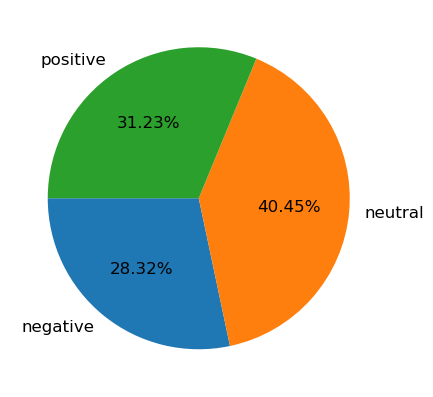

In [7]:
# Unique target values and their count
sentiment_counts = df.groupby(['sentiment']).size()
print(sentiment_counts)

# visualizing the sentiments
fig = plt.figure(figsize=(5,5), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.2f%%', startangle=180, fontsize=12, label="")

In [8]:
#Check the targets to be upsampled if any
df_major = df[df['sentiment'] == 'neutral']
df_minor1 = df[df['sentiment'] == 'positive']
df_minor2 = df[df['sentiment'] == 'negative']

In [9]:
print(df_major.shape, df_minor1.shape, df_minor2.shape)

(11117, 4) (8582, 4) (7781, 4)


In [10]:
# Upsample minority targets
def resample(sample):
    upsample = sklearn.utils.resample(sample, replace = True, n_samples = df_major.shape[0], random_state = 100)
    return upsample
    
pos_upsample = resample(df_minor1)
neg_upsample = resample(df_minor2)

sentiment
negative    11117
neutral     11117
positive    11117
dtype: int64


<AxesSubplot:>

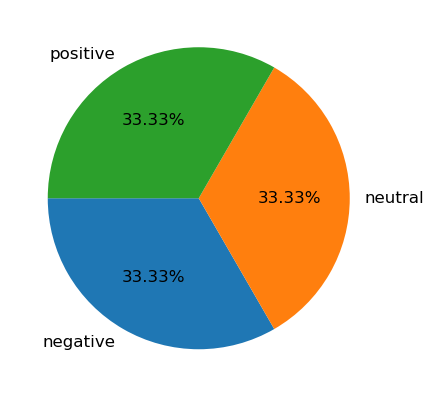

In [11]:
#Concatenate all the upsampled dataframes 

df_upsampled = pd.concat([df_major, pos_upsample, neg_upsample])

# Unique target values and their count
sntmnt_count_up = df_upsampled.groupby(['sentiment']).size()
print(sntmnt_count_up)

# visualizing the sentiments
fig = plt.figure(figsize=(5,5), dpi=100)
ax = plt.subplot(111)
sntmnt_count_up.plot.pie(ax=ax, autopct='%1.2f%%', startangle=180, fontsize=12, label="")

All the unique sentiments are equally sampled

In [12]:
print(df_major.shape, pos_upsample.shape, neg_upsample.shape)

(11117, 4) (11117, 4) (11117, 4)


In [13]:
#shuffle the rows

tweetdf = df_upsampled.sample(frac=1).reset_index(drop=True)
tweetdf

,textID,text,selected_text,sentiment
0,6eba0f4a1b,Sad. I don`t know what to do with my life. Eve...,Sad. I,negative
1,b201acdcdc,"Had lunch at Bittercreek, they were out of Ho...","o, so all is still right in the world.",positive
2,59bf010e42,"Hahahah, I will be using that saying from now...","Hahahah,",positive
3,3d2fcd78c8,Happy Star Wars day everyone! and Enjoy the ho...,Happy Star Wars day everyone! and Enjoy the ho...,positive
4,729b96d486,would love to talk to you but i live in Engla...,would love to talk to you but i live in Englan...,neutral
...,...,...,...,...
33346,cedb1f29ce,"Thanks, the more, the merrier","Thanks,",positive
33347,37fc54fac7,whaaaaaat? oh no! why didn`t I know you were ...,whaaaaaat? oh no! why didn`t I know you were h...,negative
33348,f16554ab38,The dj`s and partypeople were great again at C...,were great,positive
33349,9c3beb8b96,Thank you! I hope you have a great rest of yo...,Thank,positive


In [14]:
#Partition the dataframe into x(input) and y(output)

x = tweetdf.iloc[:,[1]].copy()
y = tweetdf.iloc[:,[3]].copy()


In [15]:
x.tail()

,text
33346,"Thanks, the more, the merrier"
33347,whaaaaaat? oh no! why didn`t I know you were ...
33348,The dj`s and partypeople were great again at C...
33349,Thank you! I hope you have a great rest of yo...
33350,check on ya`ll in a bit. im in for a Mother`s ...


In [16]:
y.tail()

,sentiment
33346,positive
33347,negative
33348,positive
33349,positive
33350,neutral


### Text Preprocessing

In [17]:
# Function to clean the text

def clean_tweet(tweet):
    
    #remove links
    tweet_links = re.sub(r"http\S+"," ", tweet)
    tweet_links = re.sub(r"www.S+"," ", tweet_links)
    
    #remove punctuations
    tweet_punc = "".join([char for char in tweet_links if char not in string.punctuation])
    
    #tokenization
    tweet_token = word_tokenize(tweet_punc)
    
    #remove stopwords and lowercase
    stop_words = nltk.corpus.stopwords.words('english')
    tweet_stops = [word.lower() for word in tweet_token if word not in stop_words]
    
    #stemming and lemmetaization
    stm_lem = WordNetLemmatizer()
    cleaned_tweet = " ".join([stm_lem.lemmatize(word) for word in tweet_stops])
    
    return cleaned_tweet
    
    

In [18]:
# Check clean_tweet function

# original text
print("Original text:\n", x['text'][30])

# Cleaned text
print("cleaned text: \n", clean_tweet(x.text[30]))

Original text:
  woo! I was at whole earth tonight, maybe tomorrow some, let me know if you come back. Yay for wikipedia
cleaned text: 
 woo i whole earth tonight maybe tomorrow let know come back yay wikipedia


In [19]:
#Clean all the tweets

index = 0
for tweet in x.text:
    x.text[index] = clean_tweet(tweet)
    index += 1

In [20]:
#tfidf vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvectorizer = TfidfVectorizer()

In [21]:
x_tfidf = tfidfvectorizer.fit_transform(x['text'].tolist()).toarray()

In [22]:
tfidf_columns = tfidfvectorizer.get_feature_names()

### Train & Implement Multinomial Naive Bayes model

In [23]:
#partition the dataframes into train and test dfs
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_tfidf, y, test_size=0.30, random_state=72)

In [24]:
# Mapping the text ouput to numerical output

output_map = {'neutral': 0, 'positive': 1, 'negative': 2}
y_train = y_train['sentiment'].map(output_map)
y_test = y_test['sentiment'].map(output_map)

In [25]:
# Train Multinomial Naive bayes model using training dataset

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=0.005)
model = nb.fit(x_train, y_train)

In [26]:
# Predict the train values

train_pred = nb.predict(x_train)

In [27]:
#Evaluate scores

import sklearn.metrics as skm

print(skm.classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       0.91      0.84      0.88      7762
           1       0.91      0.94      0.92      7787
           2       0.89      0.94      0.92      7796

    accuracy                           0.91     23345
   macro avg       0.91      0.91      0.91     23345
weighted avg       0.91      0.91      0.91     23345



**Accuracy of train data:** 0.91


In [28]:
# Predict the test values

test_pred = nb.predict(x_test)

In [29]:
#Evaluate test scores

print(skm.classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.65      0.55      0.59      3355
           1       0.74      0.79      0.76      3330
           2       0.72      0.80      0.76      3321

    accuracy                           0.71     10006
   macro avg       0.71      0.71      0.71     10006
weighted avg       0.71      0.71      0.71     10006



In [30]:
from sklearn.metrics import confusion_matrix

conf_mtx = confusion_matrix(y_train, train_pred)

conf_mtx_df = pd.DataFrame(conf_mtx,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
conf_mtx_df

,Negative,Neutral,Positive
Negative,6529,549,684
Neutral,320,7281,186
Positive,309,148,7339


In [31]:
conf_mtx_test = confusion_matrix(y_test, test_pred)

conf_mtx_df_test = pd.DataFrame(conf_mtx_test,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
conf_mtx_df_test

,Negative,Neutral,Positive
Negative,1840,724,791
Neutral,497,2615,218
Positive,498,173,2650


**Sentiment Word Cloud**

In [32]:
import wordcloud
from wordcloud import WordCloud
from wordcloud import STOPWORDS

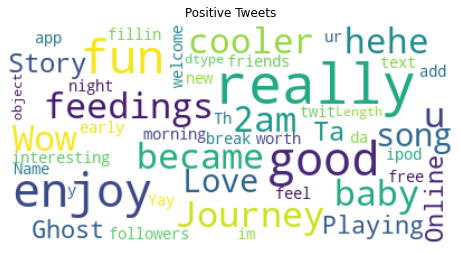

In [33]:
#Positive tweets word cloud

pos_tweets = df['text'][df['sentiment'] == 'positive']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
pos_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(pos_tweets))
plt.figure(figsize=(8,8))
plt.title("Positive Tweets")
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

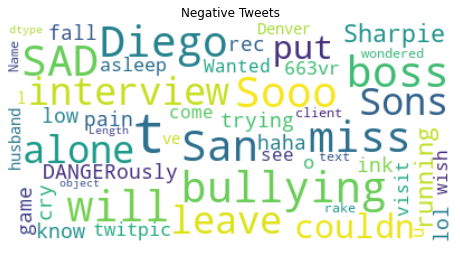

In [34]:
#Negative tweets word cloud

neg_tweets = df['text'][df['sentiment'] == 'negative']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
neg_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(neg_tweets))
plt.figure(figsize=(8,8))
plt.title("Negative Tweets")
plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

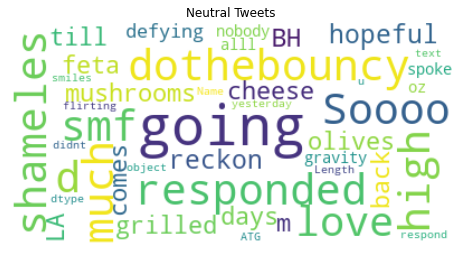

In [35]:
# Neutral tweets word cloud

neu_tweets = df['text'][df['sentiment'] == 'neutral']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
neu_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(neu_tweets))
plt.figure(figsize=(8,8))
plt.title("Neutral Tweets")
plt.imshow(neu_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()